<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: C:\Users\mxj210016\Desktop\Python_Learning\Coursera\Time_Series_LSTM\C4\W4\ungraded_labs\Sunspots.csv

  0%|          | 0.00/70.8k [00:00<?, ?B/s]
100%|##########| 70.8k/70.8k [00:00<00:00, 71.0MB/s]


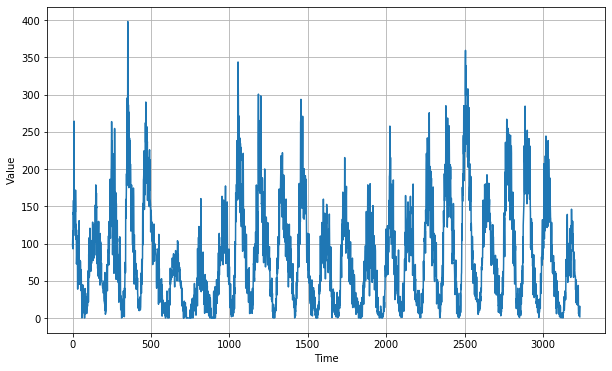

In [4]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

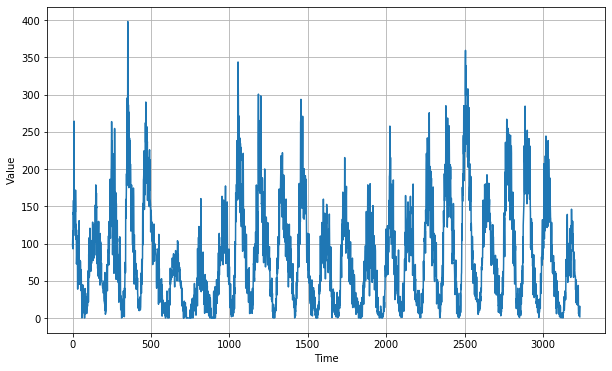

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 116ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 1s 100ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 1s 101ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 1s 102ms/step - loss: 72.2678 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 1s 102ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 1s 100ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 1s 104ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 1s 102ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 1s 104ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/

12/12 [==============================] - 1s 108ms/step - loss: 48.2469 - mae: 48.7443
Epoch 83/100
12/12 [==============================] - 1s 104ms/step - loss: 53.1387 - mae: 53.6366
Epoch 84/100
12/12 [==============================] - 1s 106ms/step - loss: 53.0097 - mae: 53.5079
Epoch 85/100
12/12 [==============================] - 1s 110ms/step - loss: 51.2053 - mae: 51.7034
Epoch 86/100
12/12 [==============================] - 1s 106ms/step - loss: 51.0724 - mae: 51.5700
Epoch 87/100
12/12 [==============================] - 1s 109ms/step - loss: 55.3364 - mae: 55.8343
Epoch 88/100
12/12 [==============================] - 1s 105ms/step - loss: 51.0838 - mae: 51.5817
Epoch 89/100
12/12 [==============================] - 1s 107ms/step - loss: 70.2469 - mae: 70.7457
Epoch 90/100
12/12 [==============================] - 1s 107ms/step - loss: 59.2749 - mae: 59.7728
Epoch 91/100
12/12 [==============================] - 1s 104ms/step - loss: 54.9524 - mae: 55.4505
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

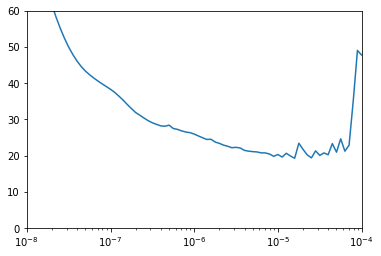

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 54ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 2s 50ms/step - loss: 25.7653 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 2s 49ms/step - loss: 22.0745 - mae: 22.5682
Epoch 4/500
30/30 [==============================] - 2s 53ms/step - loss: 20.4645 - mae: 20.9573
Epoch 5/500
30/30 [==============================] - 2s 54ms/step - loss: 19.7108 - mae: 20.2033
Epoch 6/500
30/30 [==============================] - 2s 54ms/step - loss: 19.2560 - mae: 19.7482
Epoch 7/500
30/30 [==============================] - 2s 54ms/step - loss: 18.6421 - mae: 19.1339
Epoch 8/500
30/30 [==============================] - 2s 57ms/step - loss: 18.2115 - mae: 18.7029
Epoch 9/500
30/30 [==============================] - 2s 54ms/step - loss: 18.1294 - mae: 18.6209
Epoch 10/500
30/30 [==============================] - 2s 56ms/step - loss: 17.8859 - mae: 18.3768
Epoch 11/500
30/30 [=========

Epoch 83/500
30/30 [==============================] - 2s 57ms/step - loss: 16.3660 - mae: 16.8543: 1s - loss: 1 - ETA: 0s - loss: 16.3575 - mae: 16.845
Epoch 84/500
30/30 [==============================] - 2s 57ms/step - loss: 16.4049 - mae: 16.8930
Epoch 85/500
30/30 [==============================] - 2s 58ms/step - loss: 16.5786 - mae: 17.0676
Epoch 86/500
30/30 [==============================] - 2s 58ms/step - loss: 16.4434 - mae: 16.9319
Epoch 87/500
30/30 [==============================] - 2s 60ms/step - loss: 16.5147 - mae: 17.0034
Epoch 88/500
30/30 [==============================] - 2s 57ms/step - loss: 16.4613 - mae: 16.9504
Epoch 89/500
30/30 [==============================] - 2s 60ms/step - loss: 16.3889 - mae: 16.8771
Epoch 90/500
30/30 [==============================] - 2s 57ms/step - loss: 16.3889 - mae: 16.8775
Epoch 91/500
30/30 [==============================] - 2s 58ms/step - loss: 16.4328 - mae: 16.9219: 1s - loss:
Epoch 92/500
30/30 [==============================] 

30/30 [==============================] - 2s 52ms/step - loss: 16.2794 - mae: 16.7684
Epoch 164/500
30/30 [==============================] - 2s 53ms/step - loss: 15.9204 - mae: 16.4089
Epoch 165/500
30/30 [==============================] - 2s 53ms/step - loss: 15.9216 - mae: 16.4101
Epoch 166/500
30/30 [==============================] - 2s 53ms/step - loss: 15.9016 - mae: 16.3900
Epoch 167/500
30/30 [==============================] - 2s 53ms/step - loss: 15.9258 - mae: 16.4143
Epoch 168/500
30/30 [==============================] - 2s 56ms/step - loss: 16.0726 - mae: 16.5614
Epoch 169/500
30/30 [==============================] - 2s 55ms/step - loss: 15.8678 - mae: 16.3560
Epoch 170/500
30/30 [==============================] - 2s 54ms/step - loss: 15.9780 - mae: 16.4663
Epoch 171/500
30/30 [==============================] - 2s 53ms/step - loss: 15.8873 - mae: 16.3757
Epoch 172/500
30/30 [==============================] - 2s 53ms/step - loss: 15.8883 - mae: 16.3767
Epoch 173/500
30/30 [===

30/30 [==============================] - 2s 56ms/step - loss: 15.5569 - mae: 16.0446
Epoch 245/500
30/30 [==============================] - 2s 51ms/step - loss: 15.5199 - mae: 16.0077
Epoch 246/500
30/30 [==============================] - 2s 53ms/step - loss: 15.5719 - mae: 16.0599
Epoch 247/500
30/30 [==============================] - 2s 54ms/step - loss: 15.5276 - mae: 16.0155
Epoch 248/500
30/30 [==============================] - 2s 53ms/step - loss: 15.7182 - mae: 16.2065
Epoch 249/500
30/30 [==============================] - 2s 52ms/step - loss: 15.5314 - mae: 16.0194
Epoch 250/500
30/30 [==============================] - 2s 52ms/step - loss: 15.5048 - mae: 15.9925
Epoch 251/500
30/30 [==============================] - 2s 53ms/step - loss: 15.5515 - mae: 16.0392
Epoch 252/500
30/30 [==============================] - 2s 53ms/step - loss: 15.5578 - mae: 16.0455
Epoch 253/500
30/30 [==============================] - 2s 52ms/step - loss: 15.4703 - mae: 15.9578
Epoch 254/500
30/30 [===

30/30 [==============================] - 2s 55ms/step - loss: 15.2695 - mae: 15.7566
Epoch 327/500
30/30 [==============================] - 2s 52ms/step - loss: 15.1349 - mae: 15.6212
Epoch 328/500
30/30 [==============================] - 2s 52ms/step - loss: 15.1698 - mae: 15.6565
Epoch 329/500
30/30 [==============================] - 2s 52ms/step - loss: 15.1784 - mae: 15.6649
Epoch 330/500
30/30 [==============================] - 2s 53ms/step - loss: 15.2173 - mae: 15.7042
Epoch 331/500
30/30 [==============================] - 2s 52ms/step - loss: 15.1490 - mae: 15.6357
Epoch 332/500
30/30 [==============================] - 2s 51ms/step - loss: 15.0773 - mae: 15.5635
Epoch 333/500
30/30 [==============================] - 2s 52ms/step - loss: 15.1311 - mae: 15.6175
Epoch 334/500
30/30 [==============================] - 2s 51ms/step - loss: 15.1099 - mae: 15.5960
Epoch 335/500
30/30 [==============================] - 2s 54ms/step - loss: 15.2075 - mae: 15.6943
Epoch 336/500
30/30 [===

30/30 [==============================] - 2s 55ms/step - loss: 14.8763 - mae: 15.3624
Epoch 409/500
30/30 [==============================] - 2s 52ms/step - loss: 14.9006 - mae: 15.3863
Epoch 410/500
30/30 [==============================] - 2s 52ms/step - loss: 15.1307 - mae: 15.6176
Epoch 411/500
30/30 [==============================] - 2s 54ms/step - loss: 14.8509 - mae: 15.3367
Epoch 412/500
30/30 [==============================] - 2s 52ms/step - loss: 14.9008 - mae: 15.3867
Epoch 413/500
30/30 [==============================] - 2s 52ms/step - loss: 14.8276 - mae: 15.3131
Epoch 414/500
30/30 [==============================] - 2s 53ms/step - loss: 14.8972 - mae: 15.3832
Epoch 415/500
30/30 [==============================] - 2s 53ms/step - loss: 14.9006 - mae: 15.3864
Epoch 416/500
30/30 [==============================] - 2s 52ms/step - loss: 14.9282 - mae: 15.4142
Epoch 417/500
30/30 [==============================] - 2s 52ms/step - loss: 14.9445 - mae: 15.4307
Epoch 418/500
30/30 [===

30/30 [==============================] - 2s 52ms/step - loss: 14.5392 - mae: 15.0240
Epoch 491/500
30/30 [==============================] - 2s 51ms/step - loss: 14.5469 - mae: 15.0324
Epoch 492/500
30/30 [==============================] - 2s 53ms/step - loss: 14.6233 - mae: 15.1085
Epoch 493/500
30/30 [==============================] - 2s 51ms/step - loss: 14.6111 - mae: 15.0968
Epoch 494/500
30/30 [==============================] - 2s 52ms/step - loss: 14.5317 - mae: 15.0172
Epoch 495/500
30/30 [==============================] - 2s 52ms/step - loss: 14.5592 - mae: 15.0444
Epoch 496/500
30/30 [==============================] - 2s 54ms/step - loss: 14.6459 - mae: 15.1313
Epoch 497/500
30/30 [==============================] - 2s 52ms/step - loss: 14.5965 - mae: 15.0820
Epoch 498/500
30/30 [==============================] - 2s 53ms/step - loss: 14.8405 - mae: 15.3263
Epoch 499/500
30/30 [==============================] - 2s 51ms/step - loss: 14.5189 - mae: 15.0045
Epoch 500/500
30/30 [===

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

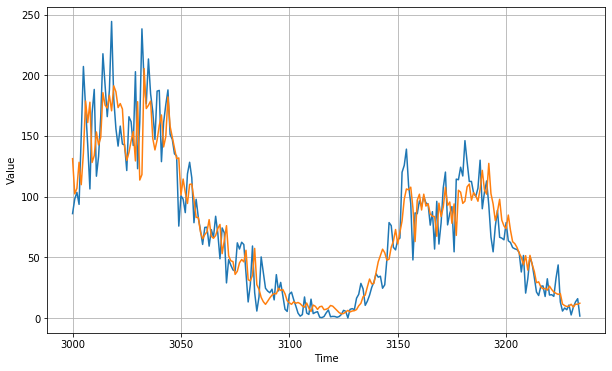

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.113851

<Figure size 432x288 with 0 Axes>

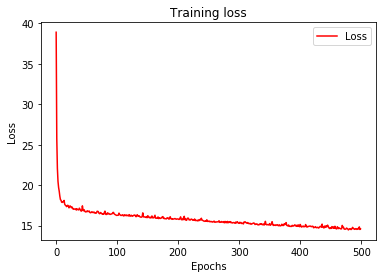

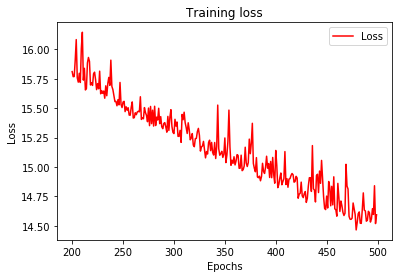

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[131.2554    102.26771   106.82093   128.27147   109.81748   135.88431
 178.79445   161.02242   177.78188   128.12733   133.72192   153.25533
 142.55913   148.84499   185.65483   175.34068   172.98271   183.3547
 170.69434   191.27089   186.31326   173.35966   176.65448   172.14005
 140.9263    129.72318   136.28528   145.81798   153.5281    129.40233
 178.1805    113.64764   118.17193   205.4626    172.5574    175.24428
 178.71922   147.93393   138.46329   146.62653   158.60602   167.26273
 140.92435   149.4055    182.11351   157.89865   149.03085   139.81471
 131.27873   131.854     101.27254   114.47561   103.438614   94.33743
 110.068954  110.39935    97.6252     82.912315   82.75057    70.87842
  65.25747    68.613144   71.01574    81.02217    67.34263    65.67593
  67.932396   73.71548    77.067444   52.994274   63.750275   76.04275
  51.199448   47.133636   46.449806   35.8963     38.501816   45.422226
  48.1653     46.248875   55.794395   31.535313   30.617662   35.15306
  57.3